# Bibliotekos

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.chunk.named_entity import shape
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from collections import Counter
import spacy
from sklearn.ensemble import StackingClassifier

# Failo skaitymas

In [2]:

# Perskaitome failą
df = pd.read_csv("spam.csv", encoding="latin-1")

df = df.iloc[:, :2]  # pasirenkam tik pirmus du stulpelius
df.columns = ['label', 'text']  # pervadinam, jei reikia
df['label'] = df['label'].str.lower()

print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None


In [3]:
df['label'] = df['label'].map({'spam': 1, 'ham': 0})

print(df.head())

   label                                               text
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...


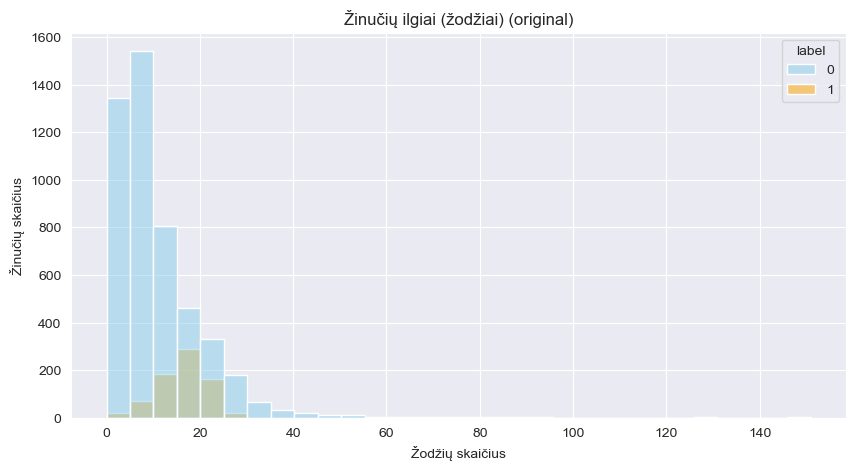

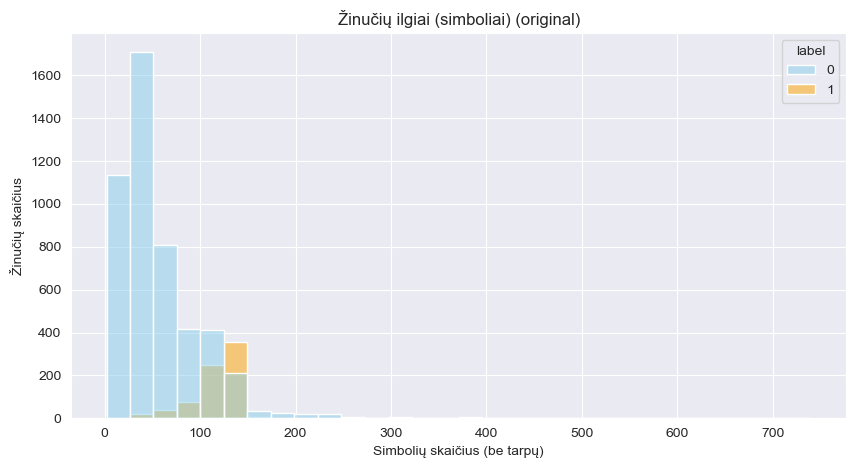

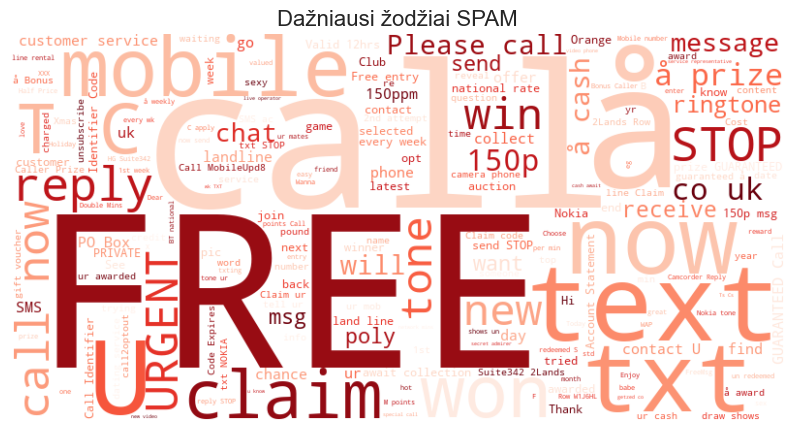

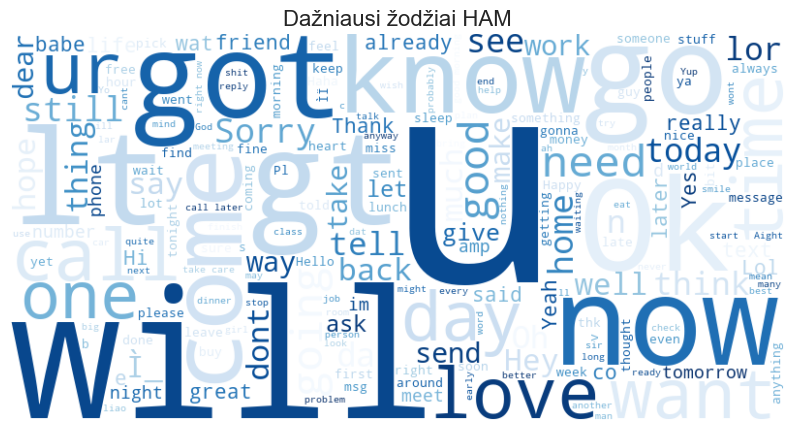

Top SPAM: [('to', 604), ('a', 358), ('your', 187), ('call', 185), ('or', 185), ('the', 178), ('2', 169), ('for', 169), ('you', 164), ('is', 143), ('Call', 136), ('on', 135), ('have', 128), ('and', 119), ('from', 116), ('ur', 107), ('with', 101), ('&', 98), ('4', 93), ('of', 93)]
Top HAM: [('to', 1530), ('you', 1458), ('I', 1436), ('the', 1019), ('a', 969), ('and', 738), ('i', 736), ('in', 734), ('u', 645), ('is', 638), ('my', 619), ('me', 537), ('of', 498), ('for', 475), ('that', 398), ('it', 375), ('your', 373), ('on', 352), ('have', 346), ('at', 333)]


In [4]:
df['word_count'] = df['text'].apply(lambda x: len([w for w in str(x).split() if w.isalpha()]))


df['char_count'] = df['text'].apply(lambda x: len(str(x).replace(" ", "")))

def plot_histograms(df, suffix=""):
    plt.figure(figsize=(10,5))
    sns.histplot(df, x='word_count', hue='label', bins=30, kde=False, palette={0:'skyblue',1:'orange'})
    plt.xlabel("Žodžių skaičius")
    plt.ylabel("Žinučių skaičius")
    plt.title(f"Žinučių ilgiai (žodžiai) {suffix}")
    plt.show()

    plt.figure(figsize=(10,5))
    sns.histplot(df, x='char_count', hue='label', bins=30, kde=False, palette={0:'skyblue',1:'orange'})
    plt.xlabel("Simbolių skaičius (be tarpų)")
    plt.ylabel("Žinučių skaičius")
    plt.title(f"Žinučių ilgiai (simboliai) {suffix}")
    plt.show()

plot_histograms(df, "(original)")

def plot_wordcloud(df, label, title):
    text = " ".join(df[df['label']==label]['text'])
    plt.figure(figsize=(10,6))
    wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds' if label==1 else 'Blues').generate(text)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

plot_wordcloud(df, 1, "Dažniausi žodžiai SPAM")
plot_wordcloud(df, 0, "Dažniausi žodžiai HAM")

def get_top_words(df, label, n=20):
    words = " ".join(df[df['label']==label]['text']).split()
    counter = Counter(words)
    return counter.most_common(n)

top_spam = get_top_words(df, 1)
top_ham = get_top_words(df, 0)
print("Top SPAM:", top_spam)
print("Top HAM:", top_ham)

In [5]:
# Sukuriame savo stop_words sąrašą
my_stop_words = {
    'the', 'a', 'an', 'and', 'or', 'in', 'on', 'of', 'to', 'for', 'is', 'are',
    'was', 'were', 'be', 'been', 'it', 'this', 'that', 'with', 'as', 'by', 'at',
    'from', 'about', 'into', 'up', 'out', 'so', 'if', 'then', 'but'
}

def remove_stopwords(text):
    words = str(text).lower().split()
    filtered = [w for w in words if w.isalpha() and w not in my_stop_words]
    return " ".join(filtered)

# Sukuriame kopiją ir pritaikome funkciją
df_sw = df.copy()
df_sw['text'] = df_sw['text'].apply(remove_stopwords)


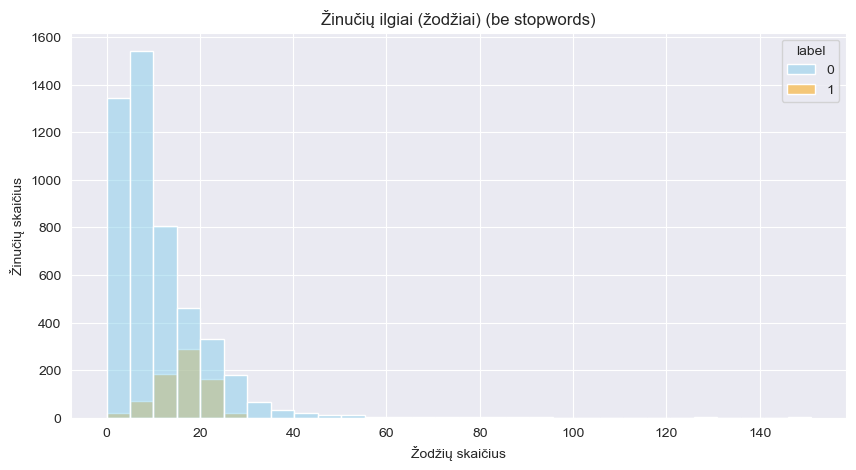

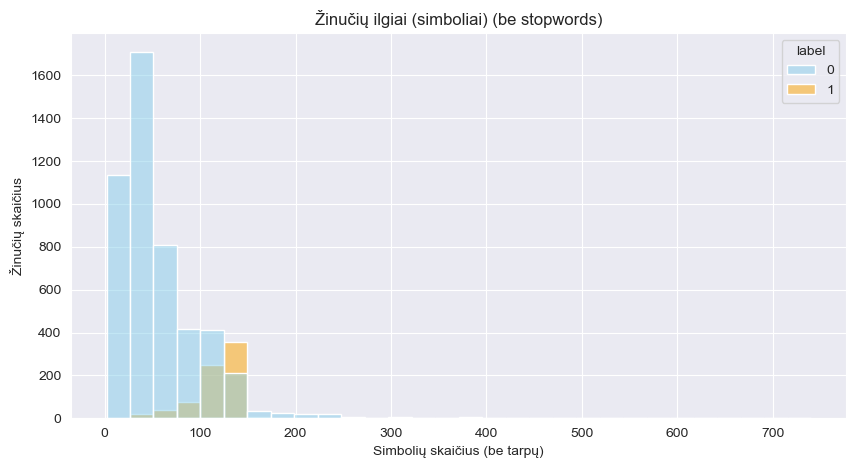

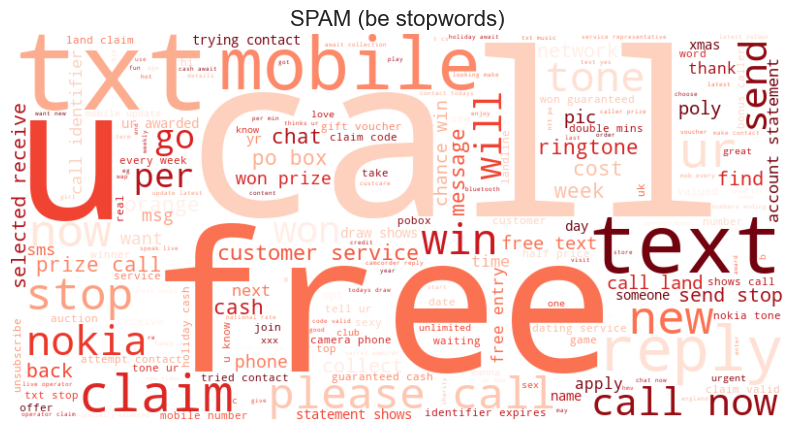

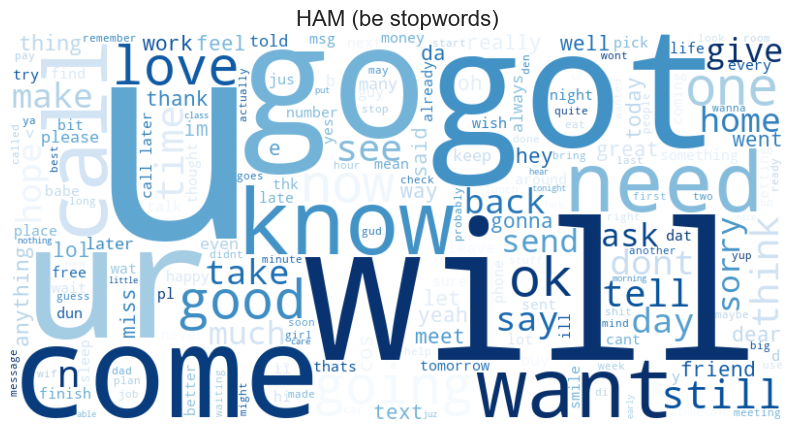

Top SPAM (be stopwords): [('call', 342), ('your', 263), ('you', 252), ('free', 180), ('ur', 144), ('txt', 136), ('have', 135), ('u', 117), ('text', 112), ('mobile', 109), ('claim', 106), ('reply', 101), ('now', 93), ('stop', 89), ('our', 85), ('get', 82), ('just', 77), ('new', 69), ('only', 66), ('send', 65)]
Top HAM (be stopwords): [('i', 2172), ('you', 1665), ('u', 874), ('my', 741), ('me', 584), ('have', 433), ('your', 413), ('not', 381), ('can', 356), ('do', 342), ('will', 331), ('we', 297), ('get', 293), ('just', 286), ('when', 270), ('how', 245), ('go', 235), ('ur', 235), ('what', 235), ('all', 231)]


In [6]:
plot_histograms(df_sw, "(be stopwords)")
plot_wordcloud(df_sw, 1, "SPAM (be stopwords)")
plot_wordcloud(df_sw, 0, "HAM (be stopwords)")

top_spam_sw = get_top_words(df_sw, 1)
top_ham_sw = get_top_words(df_sw, 0)
print("Top SPAM (be stopwords):", top_spam_sw)
print("Top HAM (be stopwords):", top_ham_sw)


# Vektorizavimas/mokymas


In [7]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=5),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}
nlp = spacy.load("en_core_web_md")

def vectorize_text(df, method="bow", vectorizer=None):
    texts = df['text'].astype(str).tolist()

    if method == "bow":
        if vectorizer is None:
            vectorizer = CountVectorizer()
            X = vectorizer.fit_transform(texts)   # treniruojam + kuriam zodyna
        else:
            X = vectorizer.transform(texts)       # naudojam esama zodyna

    elif method == "tfidf":
        if vectorizer is None:
            vectorizer = TfidfVectorizer()
            X = vectorizer.fit_transform(texts)
        else:
            X = vectorizer.transform(texts)

    elif method == "spacy_w2v":
        # spacy nereikia vectorizer
        X = np.array([nlp(t).vector for t in texts])
        vectorizer = None
    else:
        raise ValueError("Nežinomas metodas")

    return X, vectorizer

def train_and_evaluate(models, X_train, X_test, y_train, y_test, title=""):
    results = []
    print(f"\n=== {title} ===")
    for name, model in models.items():
        print(f"🔹 Treniruojamas: {name}")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results.append((name, acc))
        print(f"✅ Tikslumas: {acc:.4f}")
        print(classification_report(y_test, y_pred, digits=3))
        print("-"*50)
    return pd.DataFrame(results, columns=["Model", "Accuracy"]).sort_values(by="Accuracy", ascending=False)

def plot_results(df, title=""):
    df = df.sort_values(by="Accuracy", ascending=True)
    plt.figure(figsize=(10,6))
    plt.barh(df["Model"], df["Accuracy"], color='skyblue')
    for i, v in enumerate(df["Accuracy"]):
        plt.text(v + 0.002, i, f"{v:.3f}", va='center')
    plt.xlabel("Tikslumas")
    plt.title(title)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

# Train/Test padalinimas bei mokymas



### Vektorizacija: BOW ###

=== BOW - original ===
🔹 Treniruojamas: Logistic Regression
✅ Tikslumas: 0.9830
              precision    recall  f1-score   support

           0      0.984     0.997     0.990       978
           1      0.976     0.883     0.927       137

    accuracy                          0.983      1115
   macro avg      0.980     0.940     0.959      1115
weighted avg      0.983     0.983     0.983      1115

--------------------------------------------------
🔹 Treniruojamas: Linear SVM
✅ Tikslumas: 0.9883
              precision    recall  f1-score   support

           0      0.988     0.999     0.993       978
           1      0.992     0.912     0.951       137

    accuracy                          0.988      1115
   macro avg      0.990     0.956     0.972      1115
weighted avg      0.988     0.988     0.988      1115

--------------------------------------------------
🔹 Treniruojamas: Random Forest
✅ Tikslumas: 0.9776
              precision    recall  

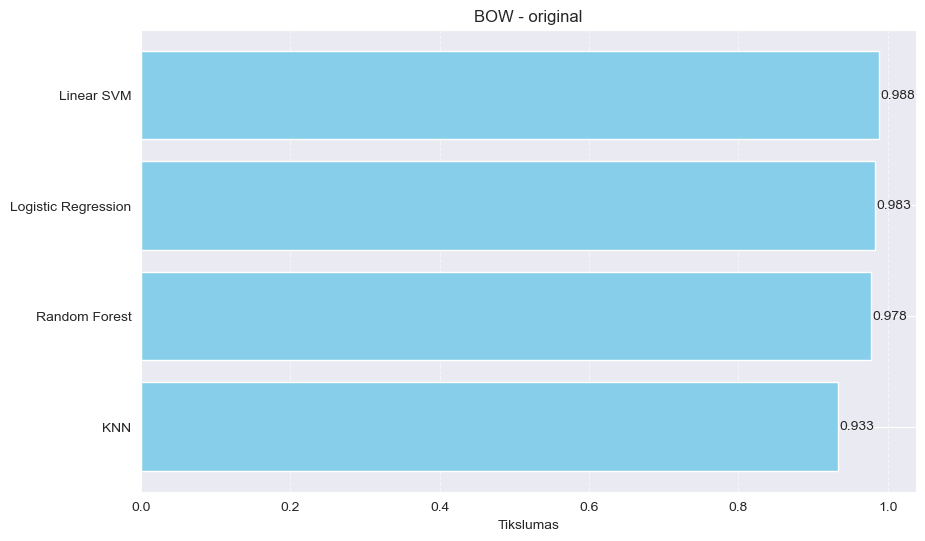


=== BOW - no_stopwords ===
🔹 Treniruojamas: Logistic Regression
✅ Tikslumas: 0.9821
              precision    recall  f1-score   support

           0      0.980     1.000     0.990       978
           1      1.000     0.854     0.921       137

    accuracy                          0.982      1115
   macro avg      0.990     0.927     0.956      1115
weighted avg      0.982     0.982     0.981      1115

--------------------------------------------------
🔹 Treniruojamas: Linear SVM
✅ Tikslumas: 0.9821
              precision    recall  f1-score   support

           0      0.984     0.996     0.990       978
           1      0.968     0.883     0.924       137

    accuracy                          0.982      1115
   macro avg      0.976     0.940     0.957      1115
weighted avg      0.982     0.982     0.982      1115

--------------------------------------------------
🔹 Treniruojamas: Random Forest
✅ Tikslumas: 0.9758
              precision    recall  f1-score   support

     

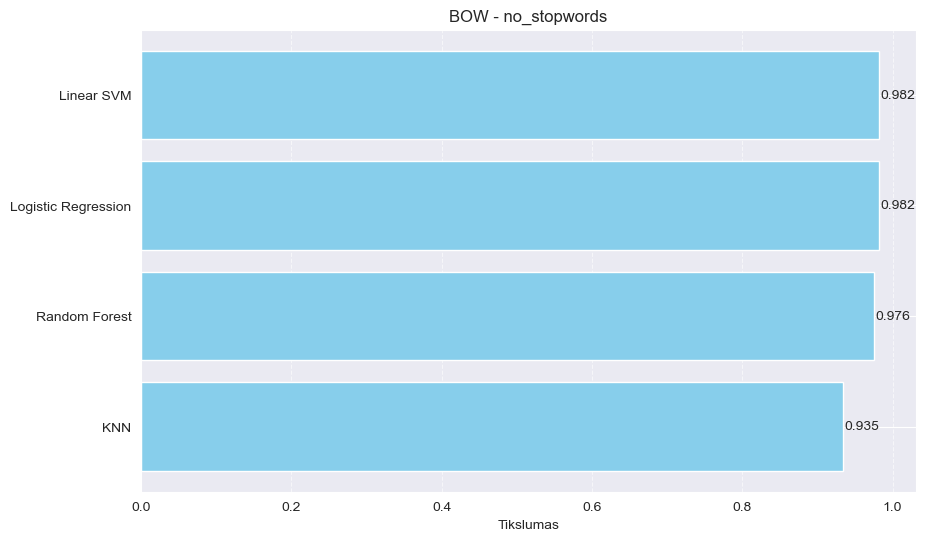



### Vektorizacija: TFIDF ###

=== TFIDF - original ===
🔹 Treniruojamas: Logistic Regression
✅ Tikslumas: 0.9677
              precision    recall  f1-score   support

           0      0.964     1.000     0.982       978
           1      1.000     0.737     0.849       137

    accuracy                          0.968      1115
   macro avg      0.982     0.869     0.915      1115
weighted avg      0.969     0.968     0.966      1115

--------------------------------------------------
🔹 Treniruojamas: Linear SVM
✅ Tikslumas: 0.9865
              precision    recall  f1-score   support

           0      0.985     1.000     0.992       978
           1      1.000     0.891     0.942       137

    accuracy                          0.987      1115
   macro avg      0.992     0.945     0.967      1115
weighted avg      0.987     0.987     0.986      1115

--------------------------------------------------
🔹 Treniruojamas: Random Forest
✅ Tikslumas: 0.9803
              precision    reca

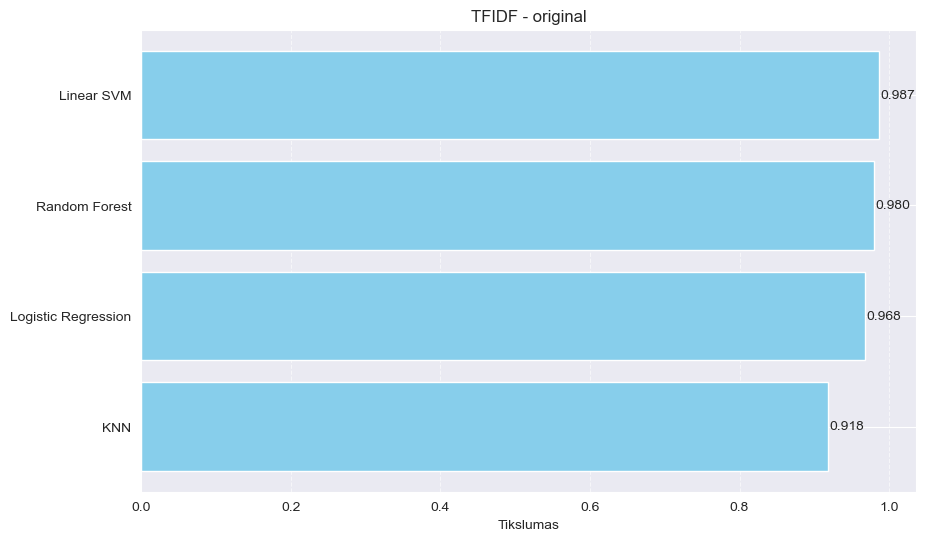


=== TFIDF - no_stopwords ===
🔹 Treniruojamas: Logistic Regression
✅ Tikslumas: 0.9578
              precision    recall  f1-score   support

           0      0.955     0.999     0.977       978
           1      0.989     0.664     0.795       137

    accuracy                          0.958      1115
   macro avg      0.972     0.832     0.886      1115
weighted avg      0.959     0.958     0.954      1115

--------------------------------------------------
🔹 Treniruojamas: Linear SVM
✅ Tikslumas: 0.9830
              precision    recall  f1-score   support

           0      0.981     1.000     0.990       978
           1      1.000     0.861     0.925       137

    accuracy                          0.983      1115
   macro avg      0.990     0.931     0.958      1115
weighted avg      0.983     0.983     0.982      1115

--------------------------------------------------
🔹 Treniruojamas: Random Forest
✅ Tikslumas: 0.9758
              precision    recall  f1-score   support

   

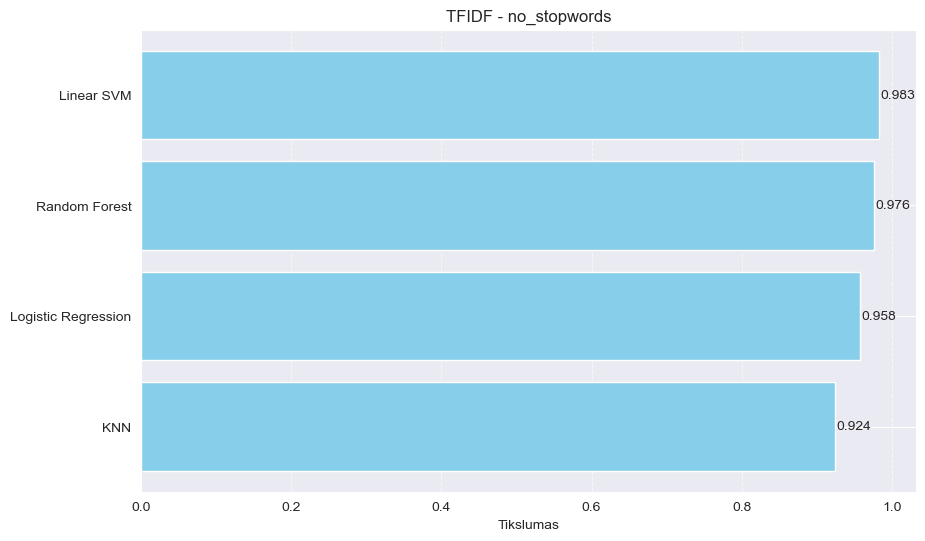



### Vektorizacija: SPACY_W2V ###

=== SPACY_W2V - original ===
🔹 Treniruojamas: Logistic Regression
✅ Tikslumas: 0.9570
              precision    recall  f1-score   support

           0      0.969     0.983     0.976       978
           1      0.862     0.774     0.815       137

    accuracy                          0.957      1115
   macro avg      0.915     0.878     0.896      1115
weighted avg      0.956     0.957     0.956      1115

--------------------------------------------------
🔹 Treniruojamas: Linear SVM
✅ Tikslumas: 0.9623
              precision    recall  f1-score   support

           0      0.976     0.982     0.979       978
           1      0.863     0.825     0.843       137

    accuracy                          0.962      1115
   macro avg      0.919     0.903     0.911      1115
weighted avg      0.962     0.962     0.962      1115

--------------------------------------------------
🔹 Treniruojamas: Random Forest
✅ Tikslumas: 0.9677
              precision

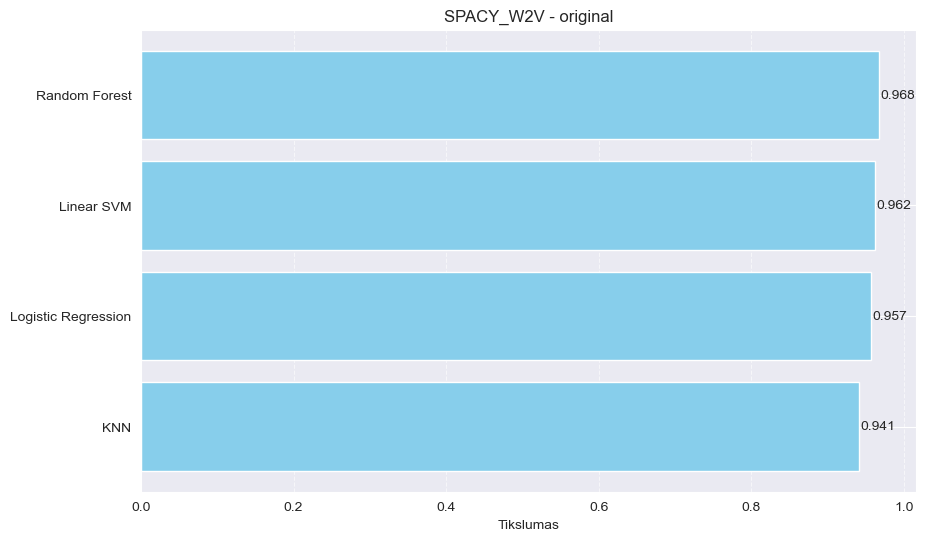


=== SPACY_W2V - no_stopwords ===
🔹 Treniruojamas: Logistic Regression
✅ Tikslumas: 0.9462
              precision    recall  f1-score   support

           0      0.961     0.979     0.970       978
           1      0.824     0.715     0.766       137

    accuracy                          0.946      1115
   macro avg      0.892     0.847     0.868      1115
weighted avg      0.944     0.946     0.945      1115

--------------------------------------------------
🔹 Treniruojamas: Linear SVM
✅ Tikslumas: 0.9489
              precision    recall  f1-score   support

           0      0.968     0.974     0.971       978
           1      0.808     0.766     0.787       137

    accuracy                          0.949      1115
   macro avg      0.888     0.870     0.879      1115
weighted avg      0.948     0.949     0.948      1115

--------------------------------------------------
🔹 Treniruojamas: Random Forest
✅ Tikslumas: 0.9596
              precision    recall  f1-score   support


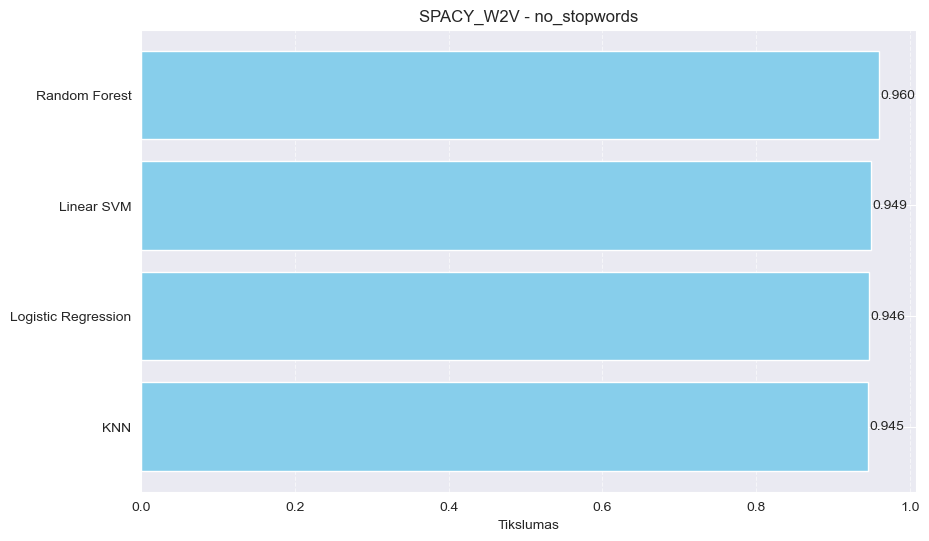

In [8]:
y = df['label'].values
results_all = {}
for method in ["bow", "tfidf", "spacy_w2v"]:
    print(f"\n\n### Vektorizacija: {method.upper()} ###")
    for data, label in [(df, "original"), (df_sw, "no_stopwords")]:
        X, vectorizer = vectorize_text(data, method)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
        results = train_and_evaluate(models, X_train, X_test, y_train, y_test, title=f"{method.upper()} - {label}")
        results_all[f"{method}_{label}"] = results
        plot_results(results, title=f"{method.upper()} - {label}")

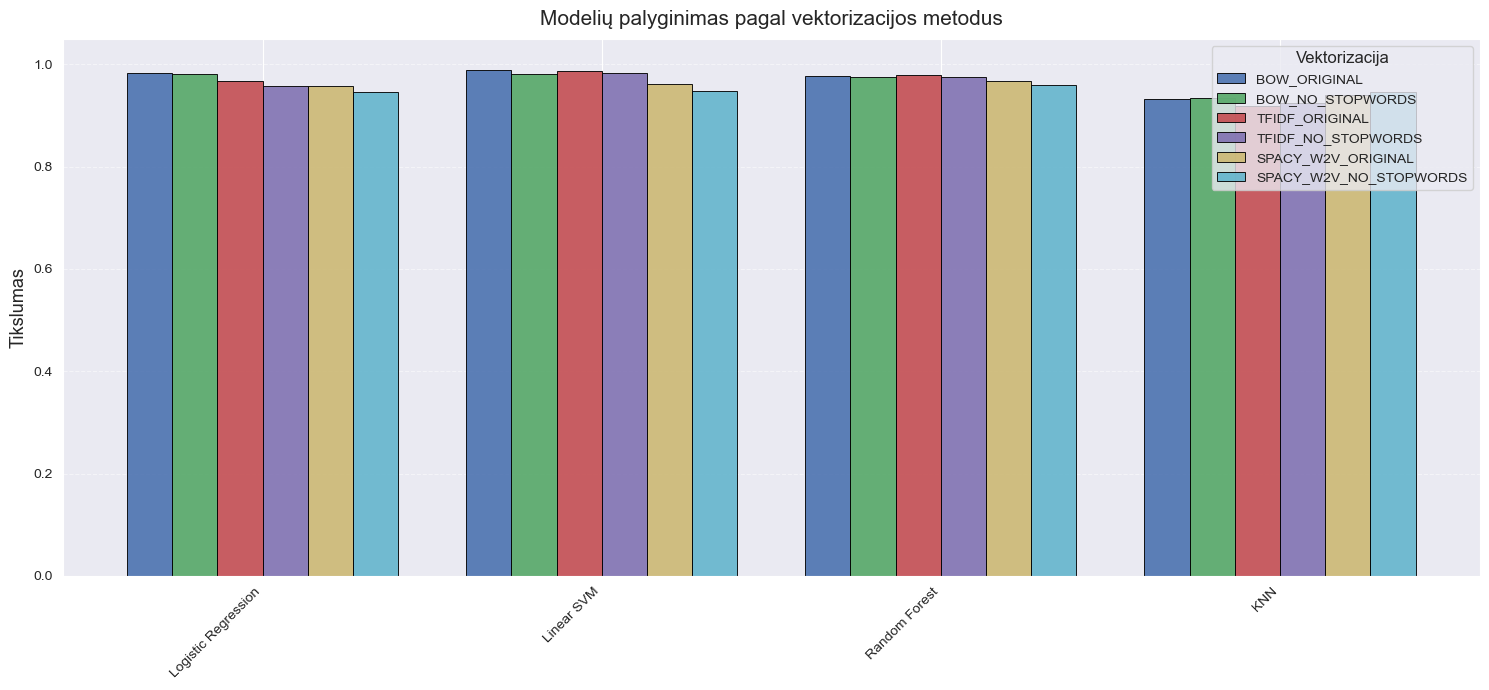

In [9]:
comparison_df = pd.DataFrame({"Model": list(models.keys())})
for key, df_res in results_all.items():
    comparison_df = comparison_df.merge(df_res, on="Model", how="left", suffixes=("", f"_{key}"))

comparison_df.columns = ["Model"] + [f"Accuracy_{k}" for k in results_all.keys()]

x = np.arange(len(comparison_df))
width = 0.12
plt.figure(figsize=(15, 7))

# Gražesnė spalvų paletė
colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B2", "#CCB974", "#64B5CD"]

n_models = len(comparison_df)
n_methods = len(comparison_df.columns) - 1
x = np.arange(n_models)
width = 0.8 / n_methods

for i, col in enumerate(comparison_df.columns[1:]):
    plt.bar(
        x + i * width - (width * (n_methods - 1) / 2),
        comparison_df[col],
        width,
        label=col.replace("Accuracy_", "").upper(),  # <-- FIX
        alpha=0.9,
        edgecolor="black",
        linewidth=0.7,
        color=colors[i % len(colors)]               # <-- spalvos dabar veiks
    )


plt.xticks(x, comparison_df["Model"], rotation=45, ha='right')
plt.ylabel("Tikslumas", fontsize=13)
plt.title("Modelių palyginimas pagal vektorizacijos metodus", fontsize=15, pad=10)
plt.ylim(0, 1.05)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Vektorizacija", title_fontsize=12, fontsize=10)

plt.tight_layout()
plt.show()

# Ensemble

In [24]:
base_models = [
    #('Logistic Regression', LogisticRegression(max_iter=1000, random_state=5)),
    ('Linear SVM', LinearSVC(random_state=5)),
    ('Random Forest', RandomForestClassifier(n_estimators=200, random_state=5))
]

In [17]:
X, vectorizer = vectorize_text(df, 'bow')
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [25]:
meta_model_svc = LogisticRegression(max_iter=1000, random_state=5)

stack_svc = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model_svc,
    passthrough=False,
    cv=5
)

stack_svc.fit(X_train, y_train)
y_pred = stack_svc.predict(X_test)

print("✅ Stacking tikslumas:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

✅ Stacking tikslumas: 0.9919282511210762
              precision    recall  f1-score   support

           0      0.991     1.000     0.995       978
           1      1.000     0.934     0.966       137

    accuracy                          0.992      1115
   macro avg      0.995     0.967     0.981      1115
weighted avg      0.992     0.992     0.992      1115

